In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.utils import to_categorical
from sklearn import preprocessing
import scipy.ndimage

from tqdm import tqdm
from dltk.io.preprocessing import *

C:\Users\wogur\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
root = '../dataset/'
ct_set = os.path.join(root,'ct_train_test/ct_train/')
mr_set = os.path.join(root,'mr_train_test/mr_train/')

class_num=7+1 # background

In [3]:
ct_list = os.listdir(ct_set)
ct_images = list()
ct_labels = list()
for ct_l in ct_list:
    if 'image' in ct_l:
        file_path = os.path.join(ct_set, ct_l)
        fn = os.listdir(file_path)
        ct_images.append(nib.load(file_path + '/' + fn[0]))
    elif 'label' in ct_l:
        file_path = os.path.join(ct_set, ct_l)
        fn = os.listdir(file_path)
        ct_labels.append(nib.load(file_path + '/' + fn[0]))

In [4]:
mr_list = os.listdir(mr_set)
mr_images = list()
mr_labels = list()
for mr_l in mr_list:
    if 'image' in mr_l:
        file_path = os.path.join(mr_set, mr_l)
        fn = os.listdir(file_path)
        mr_images.append(nib.load(file_path + '/' + fn[0]))
    elif 'label' in mr_l:
        file_path = os.path.join(mr_set, mr_l)
        fn = os.listdir(file_path)
        mr_labels.append(nib.load(file_path + '/' + fn[0]))

In [5]:
ct_cnt = len(ct_images)
mr_cnt = len(mr_images)

# image shape

In [6]:
ct_size = list()
mr_size = list()
for ct_image in ct_images:
    ct_size.append(ct_image.shape)    
for mr_image in mr_images:
    mr_size.append(mr_image.shape)

In [7]:
ct_size

[(512, 512, 363),
 (512, 512, 239),
 (512, 512, 298),
 (512, 512, 200),
 (512, 512, 177),
 (512, 512, 248),
 (512, 512, 243),
 (512, 512, 222),
 (512, 512, 293),
 (512, 512, 274),
 (512, 512, 239),
 (512, 512, 177),
 (512, 512, 211),
 (512, 512, 358),
 (512, 512, 300),
 (512, 512, 333),
 (512, 512, 283),
 (512, 512, 187),
 (512, 512, 297),
 (512, 512, 363)]

In [8]:
mr_size

[(512, 512, 160),
 (512, 512, 128),
 (288, 288, 160),
 (288, 288, 120),
 (288, 288, 130),
 (256, 256, 160),
 (288, 288, 180),
 (288, 288, 130),
 (512, 512, 120),
 (288, 288, 160),
 (288, 288, 160),
 (512, 512, 128),
 (512, 512, 112),
 (512, 512, 160),
 (340, 340, 200),
 (288, 288, 130),
 (288, 288, 140),
 (288, 288, 150),
 (288, 288, 135),
 (288, 288, 135)]

# Fix label values

MR label의 10번째 image에 잘못된 값이 들어가있다.  
label:  [  0 205 420 421 500 550 600 820 850]  
cnt:  [15494952   312719   110267    11667   245762   190593   187564   162053    61639]

신기한 점은 get_data()로 다른 변수에 array를 할당한 후에 값을 변경하면 get_data()를 할당한 mr_labels[9]의 값도 바껴있다.

In [9]:
m = mr_labels[9].get_data()
m[m==421] = 420

# image resize

In [10]:
label_encoder = preprocessing.LabelEncoder()

In [186]:
def pad3d(array):
    x0 = array.shape[0]
    x2 = array.shape[2]    
    if x0 > x2:
        height = x0
        depth = x2
    elif x2 > x0:
        height = x2
        depth = x0
    
    if (height - depth) % 2 :
        pad_front = int((height + 1 - depth) / 2)
        pad_back = int((height - 1 - depth) / 2)
    else:
        pad_front = pad_back = int((height - depth) / 2)
    
    if x0 > x2:    
        npad = ((0,0),(0,0),(pad_front,pad_back))
    elif x2 > x0:
        npad = ((pad_front,pad_back),(0,0),(0,0))
        
    array_padding = np.pad(array, npad, 'constant', constant_values=(0))
    array_padding[array_padding<0] = 0
    
    return array_padding

In [49]:
def image_preprocess(image, new_size, mask=False):
    assert np.sum(image.shape==image.shape[0])!=3    
    
    ratio = new_size / image.shape[0]
    
    image = scipy.ndimage.zoom(image, zoom=ratio, order=0)

    if mask:
        channel = 7 + 1 #background
        image = image.reshape(-1)
        image = label_encoder.fit_transform(image)
        image = to_categorical(image, class_num)
    else:
        channel = 1
    # reshape to raw shape
    image = image.reshape((new_size,)*3 + (channel,))
    return image

In [211]:
def axis_transform(image):
    idx = 0
    if np.sum(image[5,:,int(image.shape[-1]/2)]) == 0:
        image = image.T
        image = np.flip(image,axis=0)
        idx += 1
    return image, idx    

-----
# CT
## Images

In [13]:
ct_pad_images = np.zeros((len(ct_images),256,256,256,1))
for i in tqdm(range(len(ct_images))):
    image = ct_images[i].get_data()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)
    ct_pad_images[i,:,:,:,:] = image

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.57s/it]


## Labels

In [147]:
ct_pad_labels = np.zeros((len(ct_labels),256,256,256,8))
for i in tqdm(range(len(ct_labels))):
    image = ct_labels[i].get_data()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256, mask=True)
    ct_pad_labels[i,:,:,:,:] = image

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/it]


------
# MR

## Images

In [212]:
mr_pad_images = np.zeros((len(mr_images),256,256,256,1))
transform_idx = list()
for i in tqdm(range(len(mr_images))):
    image = mr_images[i].get_data()
    image, idx = axis_transform(image)
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)
    mr_pad_images[i,:,:,:,:] = image
    transform_idx.append(idx)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


## Labels

In [213]:
mr_pad_labels = np.zeros((len(mr_labels),256,256,256,8))
for i in tqdm(range(len(mr_labels))):
    image = mr_labels[i].get_data()
    if transform_idx[i]:
        image, _ = axis_transform(image)
    image = pad3d(image)
    image = image_preprocess(image, new_size=256, mask=True)
    mr_pad_labels[i,:,:,:,:] = image

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]


# CT CHECK

### 1. Check resize

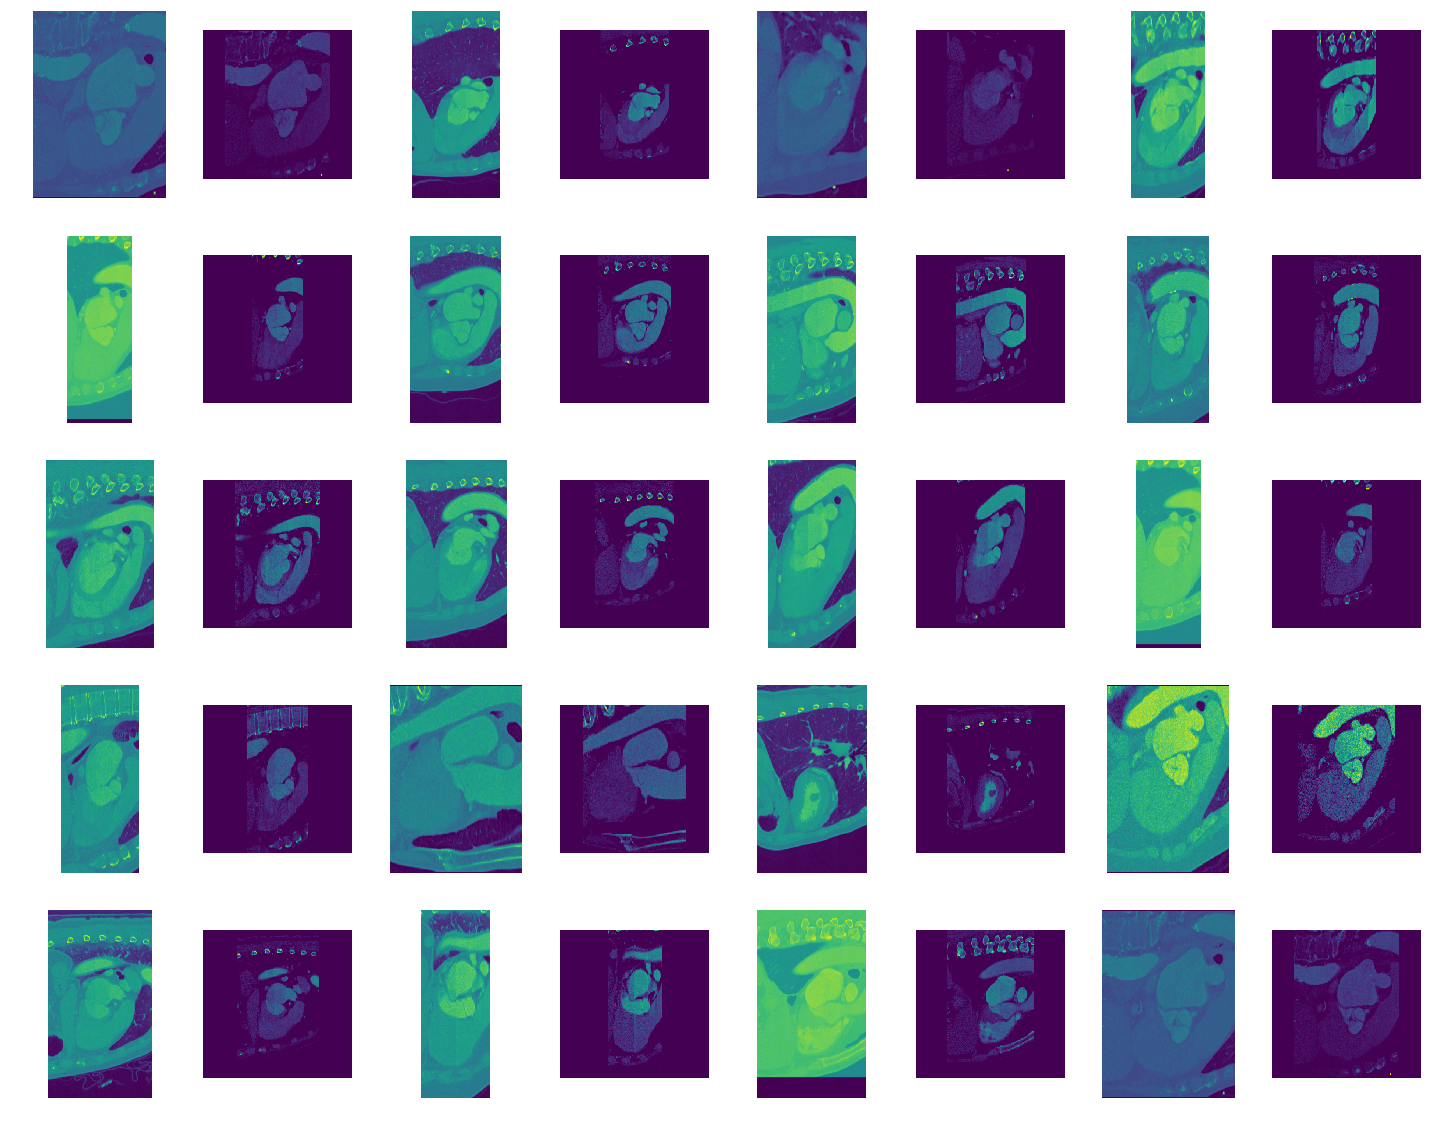

In [149]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        ax[i//8,i%8].imshow(ct_images[img_idx].get_data()[256,:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        img = ct_pad_images[pad_idx].reshape(ct_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

### 2. Check image & label matching

In [150]:
label, cnt = np.unique(np.argmax(ct_pad_labels,axis=-1),return_counts=True)
print('label: ',label)
print('cnt: ',cnt)

label:  [0 1 2 3 4 5 6 7]
cnt:  [318927700   3010371   2174804   2389956   2197691   3239933   1805458
   1798407]


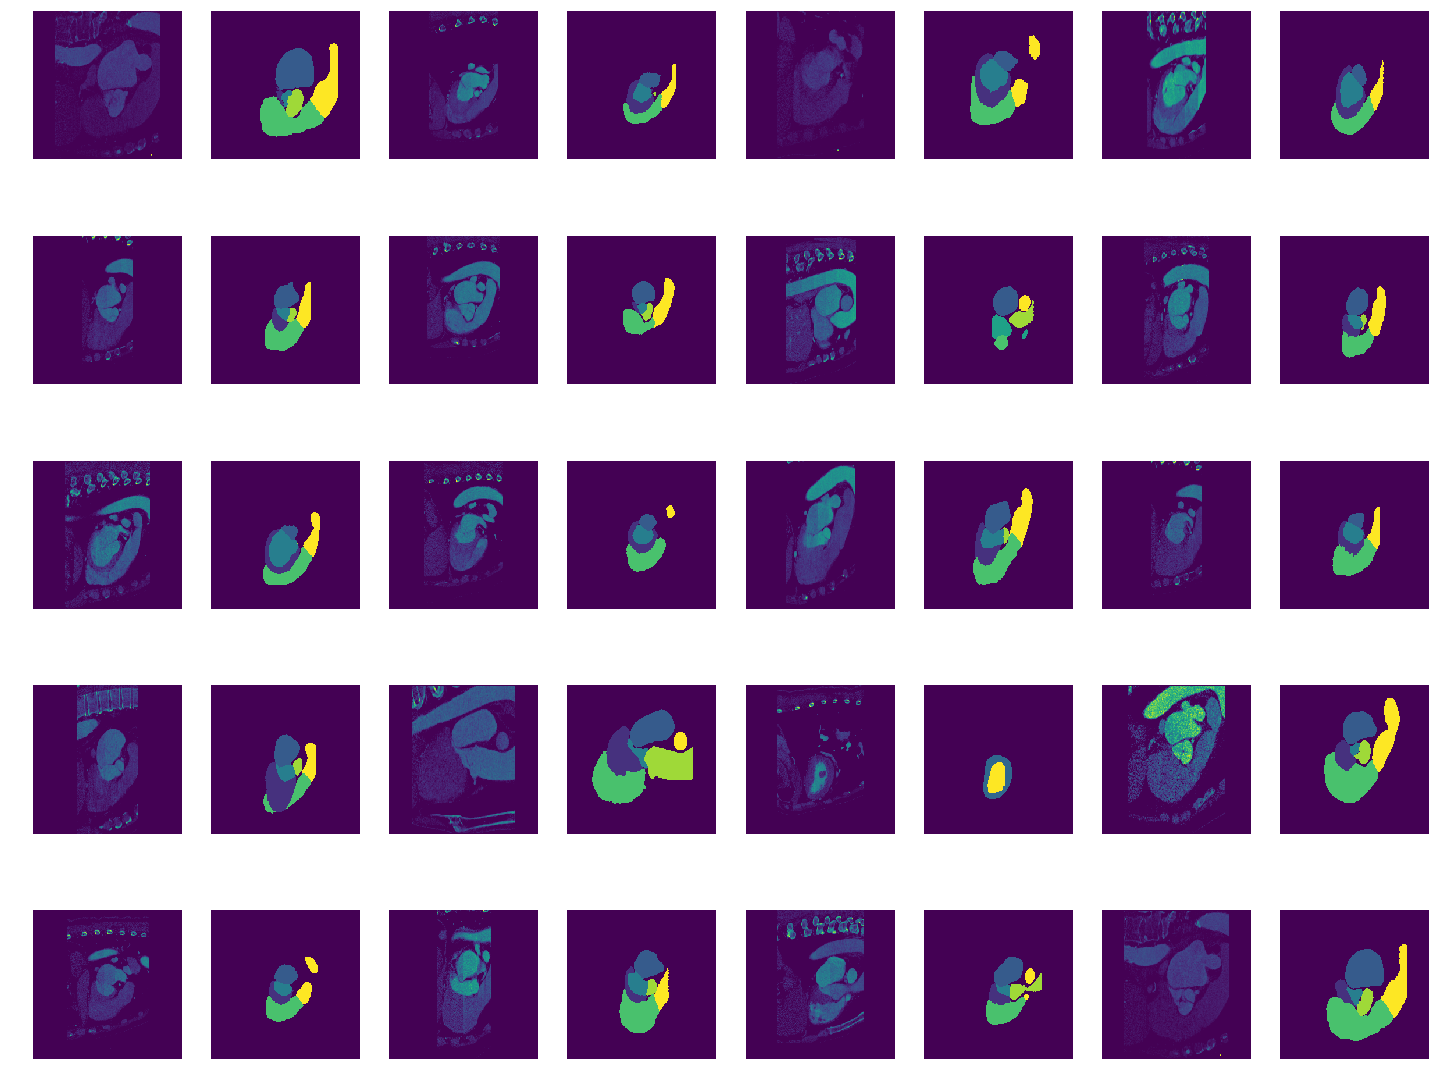

In [151]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        img = ct_pad_images[pad_idx].reshape(ct_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        mask = np.argmax(ct_pad_labels[pad_idx], axis=-1)
        ax[i//8,i%8].imshow(mask[128,:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

# MR CHECK

### CT와 동일한 축으로 맞추기
- CT와 같은축인 MR 사진

(512, 512, 160)


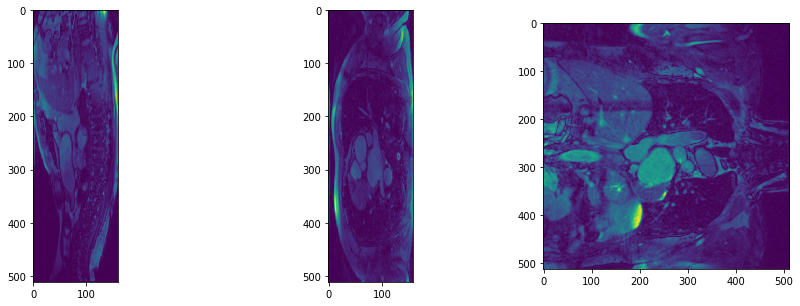

In [214]:
f, ax = plt.subplots(1,3, figsize=(15,5))
image = mr_images[0].get_data()
print(image.shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

- CT와 다른 축인 MR 사진

(288, 288, 160)
(288, 160)
(288, 160)
(288, 288)


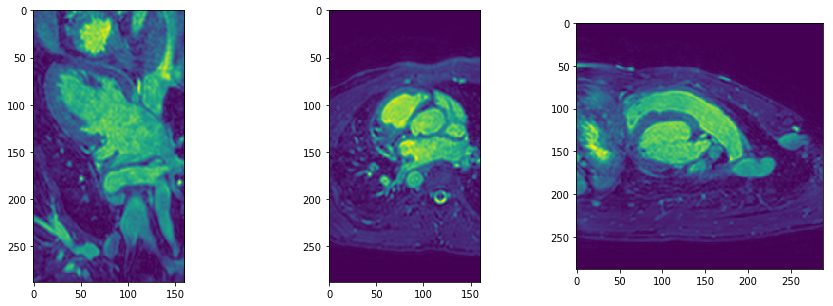

In [216]:
f, ax = plt.subplots(1,3, figsize=(15,5))
image = mr_images[9].get_data()
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

### Transpose로 축변환

In [217]:
image = image.T

(160, 288, 288)
(288, 288)
(160, 288)
(160, 288)


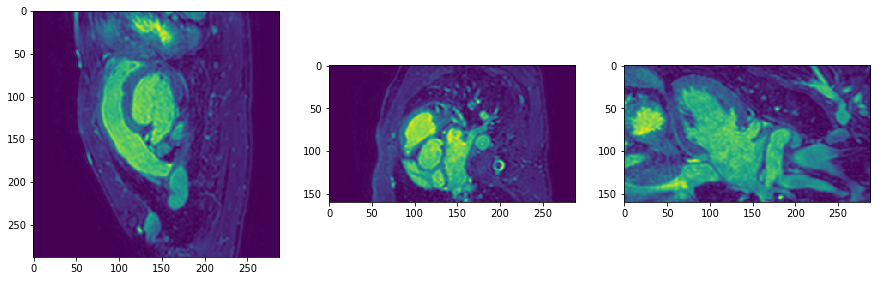

In [218]:
f, ax = plt.subplots(1,3, figsize=(15,5))
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

### Flip으로 맞춰주기

In [219]:
image = np.flip(image,axis=0)

(160, 288, 288)
(288, 288)
(160, 288)
(160, 288)


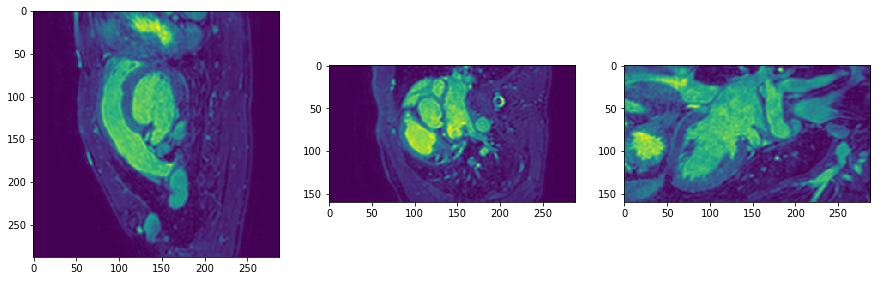

In [220]:
f, ax = plt.subplots(1,3, figsize=(15,5))
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

### check axis

- before

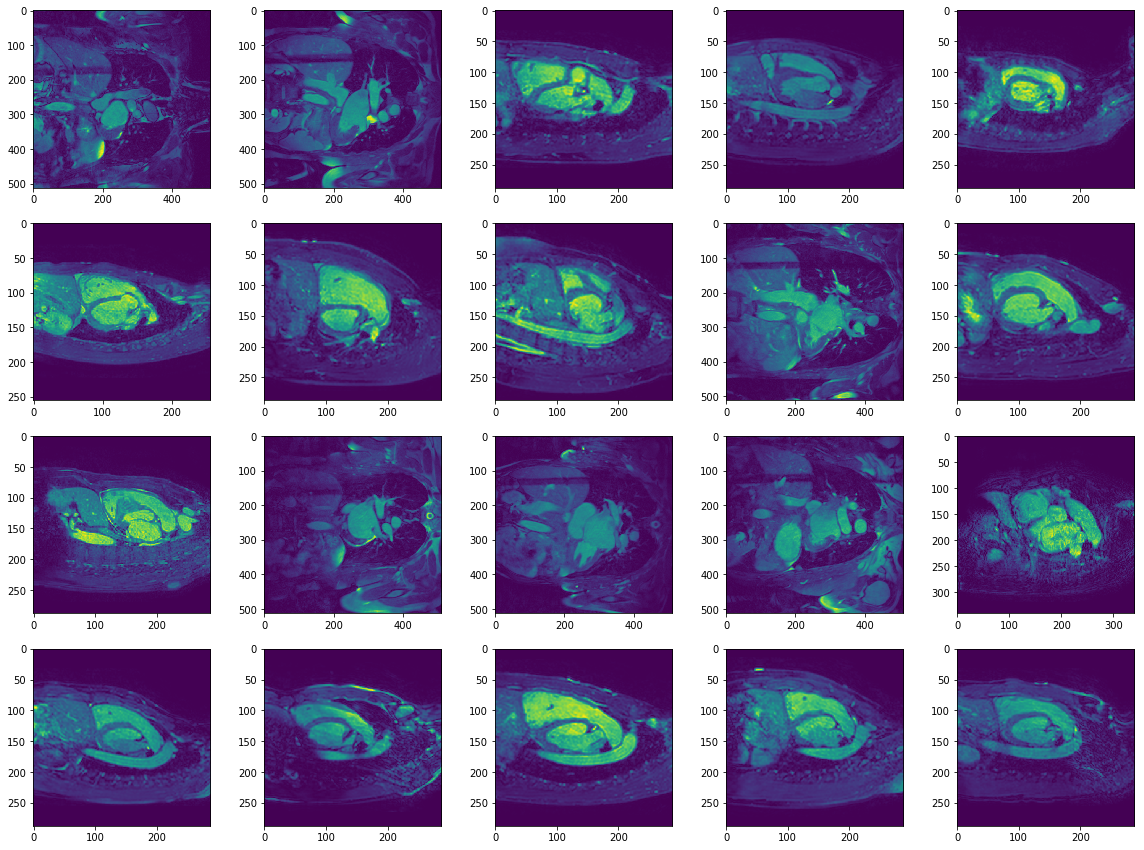

In [221]:
f, ax = plt.subplots(4,5, figsize=(20,15))
for i in range(4*5):
    ax[i//5,i%5].imshow(mr_images[i].get_data()[:,:,int(mr_images[i].shape[2]/2)])

- after

In [222]:
mr_pad_images[0].shape

(256, 256, 256, 1)

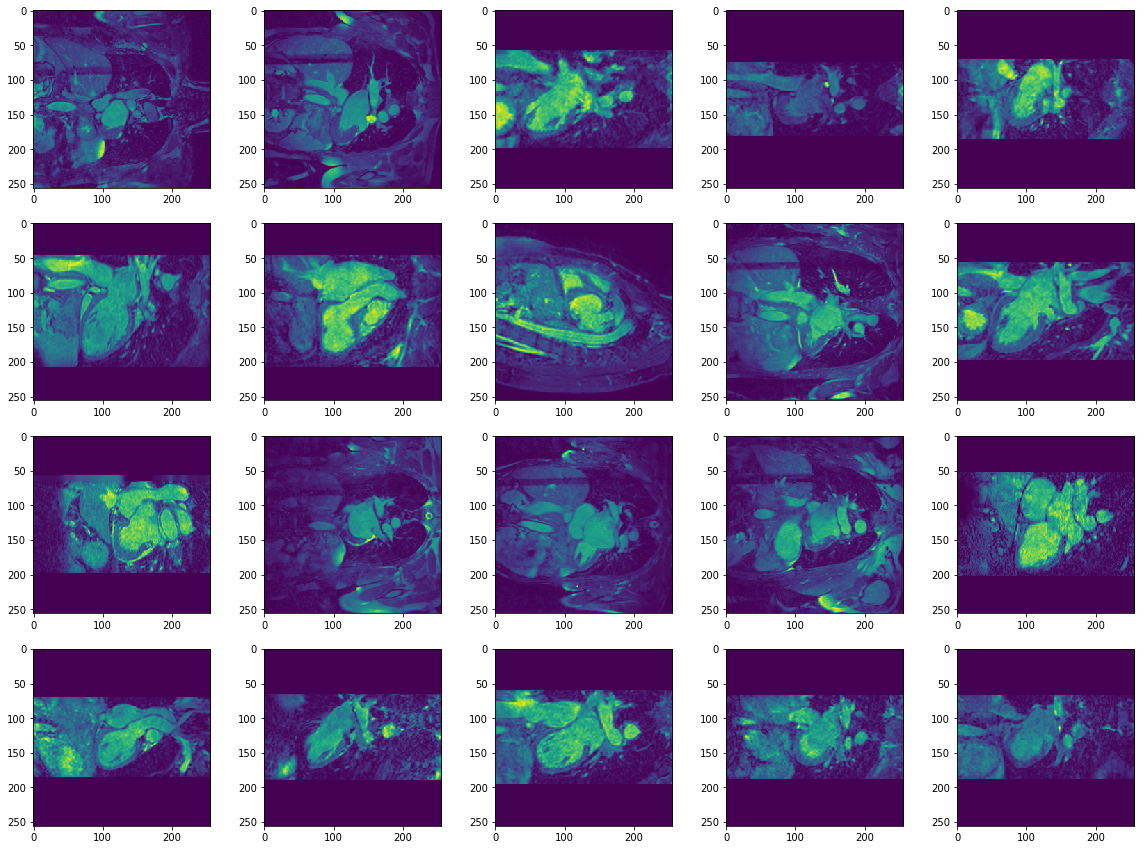

In [223]:
f, ax = plt.subplots(4,5, figsize=(20,15))
for i in range(4*5):
    img = mr_pad_images[i].reshape(mr_pad_images[i].shape[:-1])
    ax[i//5,i%5].imshow(img[:,:,int(img.shape[2]/2)])

### 1.check resize

방향이 다른게 있는 이유는 raw이미지에서 각자 모두 같은 axis로 맞추는 과정에서 transform이 있어서 padding된 이미지에서 방향이 바뀜

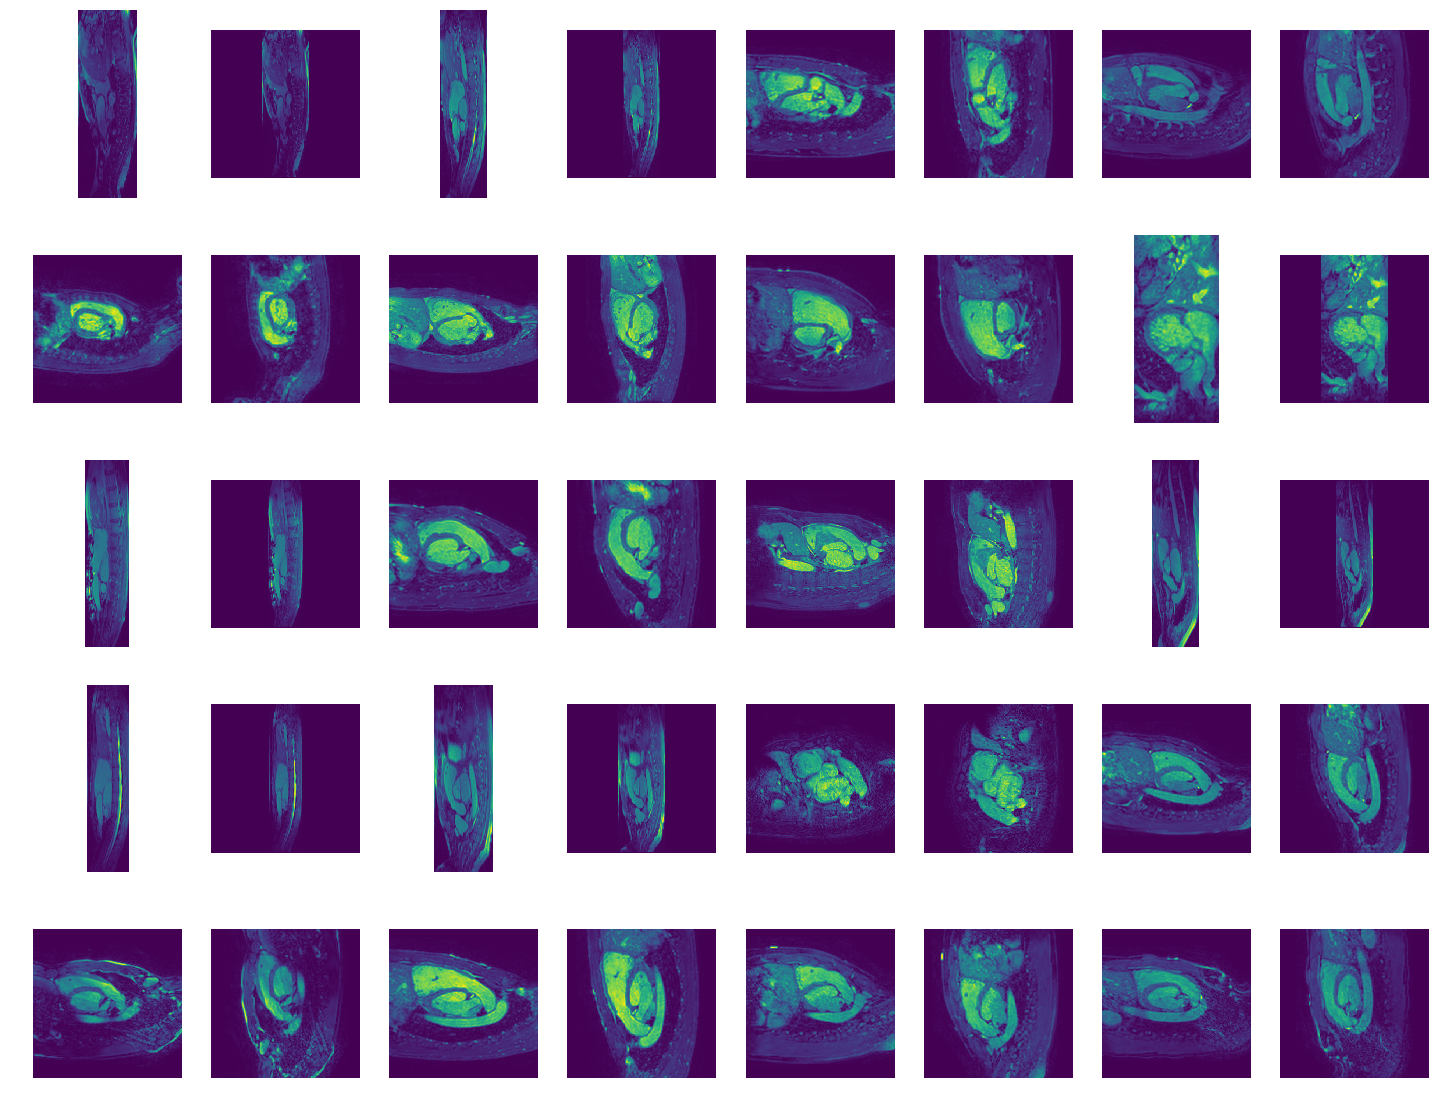

In [229]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        if transform_idx[img_idx]:
            ax[i//8,i%8].imshow(mr_images[img_idx].get_data()[:,:,int(mr_images[img_idx].shape[2]/2)])
        else:
            ax[i//8,i%8].imshow(mr_images[img_idx].get_data()[int(mr_images[img_idx].shape[0]/2),:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        img = mr_pad_images[pad_idx].reshape(mr_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[int(img.shape[0]/2),:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

### 2. Check image & label matching

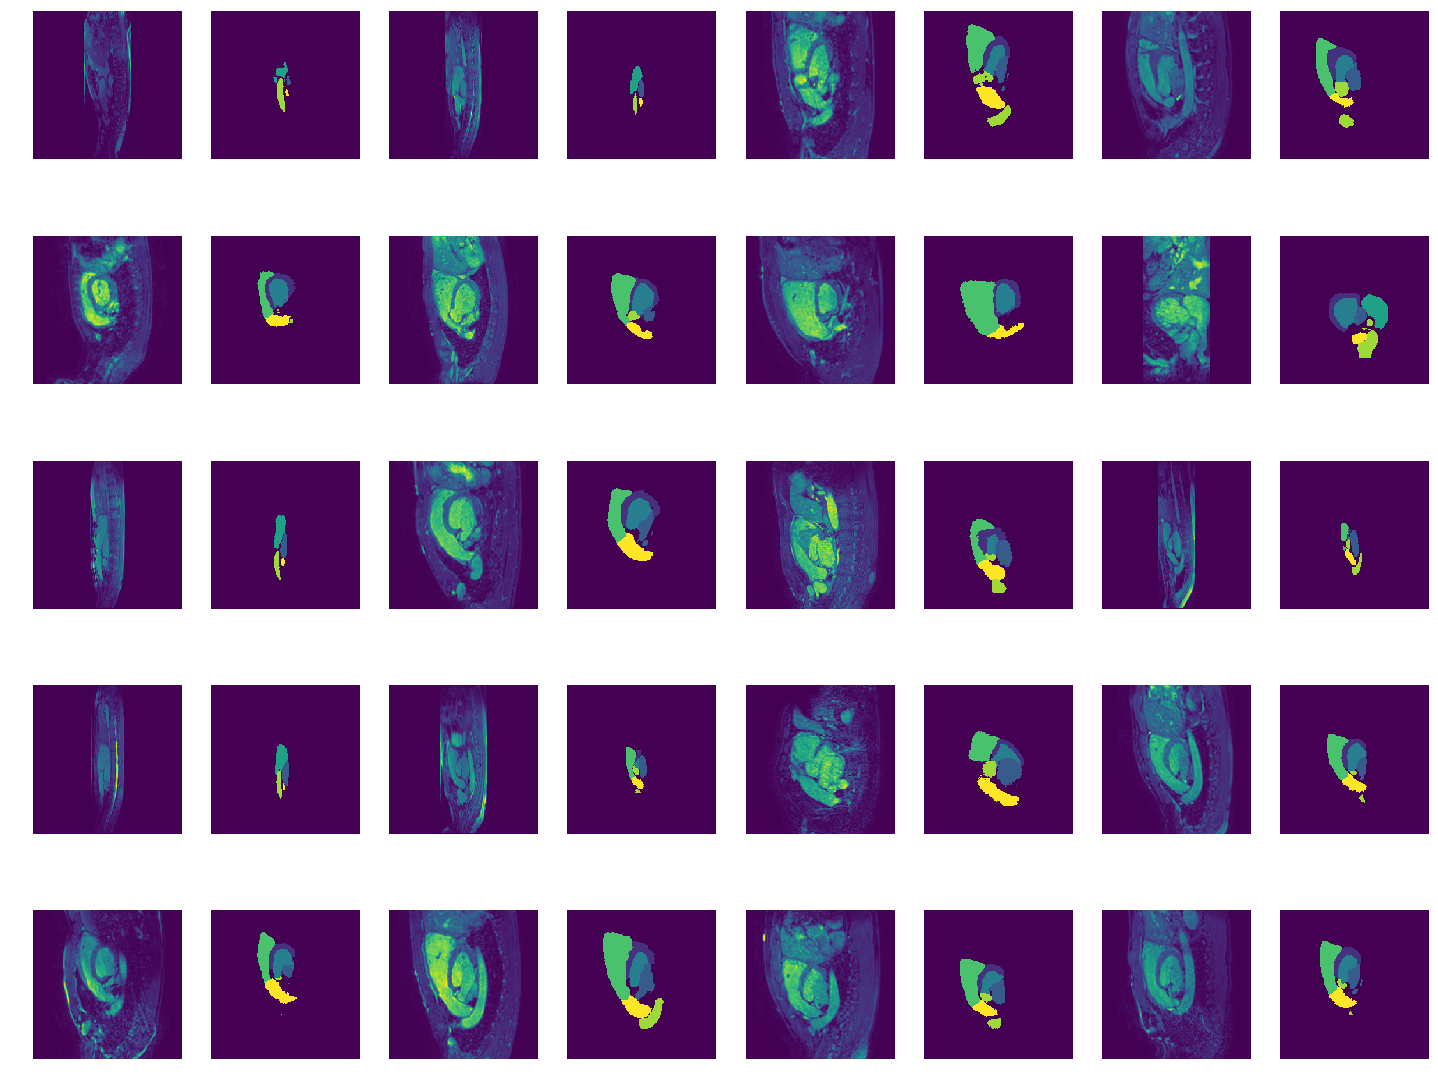

In [230]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        img = mr_pad_images[pad_idx].reshape(mr_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        mask = np.argmax(mr_pad_labels[pad_idx], axis=-1)
        ax[i//8,i%8].imshow(mask[128,:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

# One sample image by class

In [178]:
image = ct_images[0].get_data()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,'../dataset/ct_img.nii')

before shape:  (512, 512, 363)
after shape:  (256, 256, 256, 8)


In [179]:
image = ct_labels[0].get_data()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256, mask=True)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,'../dataset/ct_label.nii')

before shape:  (512, 512, 363)
after shape:  (256, 256, 256, 32)


In [180]:
image = mr_images[0].get_data()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,'../dataset/mr_img.nii')

before shape:  (512, 512, 160)
after shape:  (256, 256, 256, 2)


In [181]:
image = mr_labels[0].get_data()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256, mask=True)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,'../dataset/mr_label.nii')

before shape:  (512, 512, 160)
after shape:  (256, 256, 256, 32)


In [182]:
image = mr_labels[0].get_data()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256, mask=True)

before shape:  (512, 512, 160)


In [183]:
image.dtype

dtype('int8')

# Test image

In [231]:
ct_test_dir = '../dataset/ct_train_test/ct_test/'
ct_test_list = os.listdir(ct_test_dir)
ct_test_pad_images = list()

mr_test_dir = '../dataset/mr_train_test/mr_test/'
mr_test_list = os.listdir(mr_test_dir)
mr_test_pad_images = list()

In [232]:
ct_test_images = list()
for fn in ct_test_list:
    img_dir = os.path.join(ct_test_dir,fn)
    img_fn = os.listdir(img_dir)[0]
    im = nib.load(os.path.join(img_dir, img_fn))
    ct_test_images.append(im)
    
mr_test_images = list()
for fn in mr_test_list:
    img_dir = os.path.join(mr_test_dir,fn)
    img_fn = os.listdir(img_dir)[0]
    im = nib.load(os.path.join(img_dir, img_fn))
    mr_test_images.append(im)

In [159]:
print('='*100)
print('CT')
print('='*100)
for img in ct_test_images:
    print(img.shape)
    
print('='*100)
print('MR')
print('='*100)
for img in mr_test_images:
    print(img.shape)

CT
(512, 512, 224)
(512, 512, 200)
(512, 512, 276)
(512, 512, 206)
(512, 512, 271)
(512, 512, 271)
(512, 512, 288)
(512, 512, 261)
(512, 512, 300)
(512, 512, 274)
(512, 512, 298)
(512, 512, 256)
(512, 512, 287)
(512, 512, 224)
(512, 512, 288)
(512, 512, 243)
(512, 512, 248)
(512, 512, 211)
(512, 512, 297)
(512, 512, 298)
(512, 512, 187)
(512, 512, 239)
(512, 512, 230)
(512, 512, 276)
(512, 512, 206)
(512, 512, 247)
(512, 512, 239)
(512, 512, 358)
(512, 512, 298)
(512, 512, 293)
(512, 512, 287)
(512, 512, 177)
(512, 512, 222)
(512, 512, 247)
(512, 512, 256)
(512, 512, 333)
(512, 512, 230)
(512, 512, 261)
(512, 512, 177)
(512, 512, 283)
MR
(288, 288, 140)
(288, 288, 150)
(256, 256, 140)
(288, 288, 130)
(320, 320, 135)
(512, 512, 120)
(512, 512, 128)
(256, 256, 140)
(512, 512, 128)
(256, 256, 140)
(256, 256, 130)
(512, 512, 120)
(299, 299, 152)
(256, 256, 140)
(256, 256, 140)
(256, 256, 140)
(512, 512, 112)
(512, 512, 128)
(256, 256, 140)
(256, 256, 140)
(224, 224, 120)
(256, 256, 155)
(2

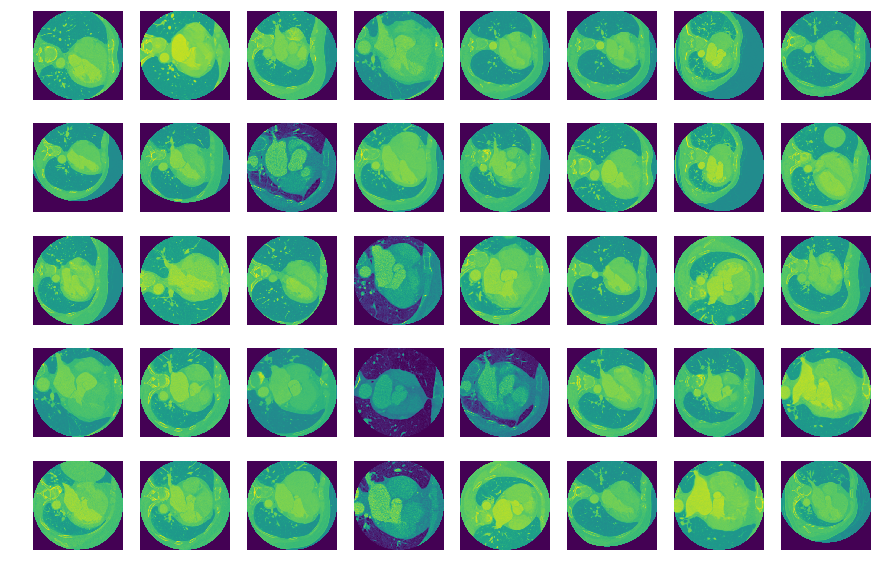

In [242]:
f, ax = plt.subplots(5,8,figsize=(15,10))
for i in range(5*8):
    img = ct_test_images[i].get_data()
    ax[i//8,i%8].imshow(img[:,:,int(img.shape[2]/2)])
    ax[i//8,i%8].axis('off')

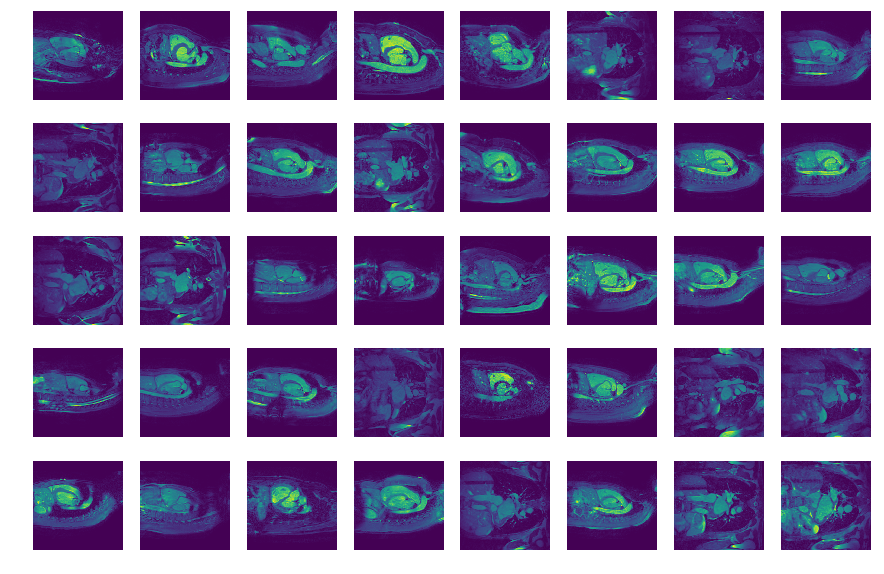

In [245]:
f, ax = plt.subplots(5,8,figsize=(15,10))
for i in range(5*8):
    img = mr_test_images[i].get_data()
    ax[i//8,i%8].imshow(img[:,:,int(img.shape[2]/2)])
    ax[i//8,i%8].axis('off')

In [ ]:
for i in tqdm(range(len(ct_test_images))):
    image = ct_test_images[i].get_data()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)

In [ ]:
for i in tqdm(range(len(mr_test_images))):
    image = mr_test_images[i].get_data()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)